In [1]:
import numpy as np
import pandas as pd
import os
import random

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.signal import periodogram, welch

from sklearn import metrics
from sklearn import svm

from helper import get_paths, get_data, _embed

SET A	Z.zip 	healthy, eyes open 

SET B 	O.zip	healthy, eyes closed

SET C	N.zip 	epileptic in the epileptogenic zone, during non-seizure time

SET D	F.zip  	epileptic in hippocampus, during non-seizure time

SET E	S.zip 	epileptic, only contained seizure activity

In [2]:
tempA = get_paths("data/Z/")
tempB = get_paths("data/O/")
tempC = get_paths("data/N/")
tempD = get_paths("data/F/")
tempE = get_paths("data/S/")

In [3]:
all_paths = tempA + tempB + tempC + tempD + tempE
Y_data = np.array([0]*200+[1]*300)

In [4]:
test_percent = 0.2
test_n = int(Y_data.size*test_percent)

test_i = random.sample(range(0, Y_data.size), test_n)
train_i = [i for i in range(Y_data.size) if i not in test_i]

In [10]:
paths_test = [all_paths[i] for i in test_i]
paths_train = [all_paths[i] for i in train_i]

In [11]:
test_features = get_features(paths_test)
train_features = get_features(paths_train)

In [13]:
Y_train = [Y_data[i] for i in train_i]
Y_test = [Y_data[i] for i in test_i]

In [14]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(train_features, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(test_features)

In [15]:
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.97


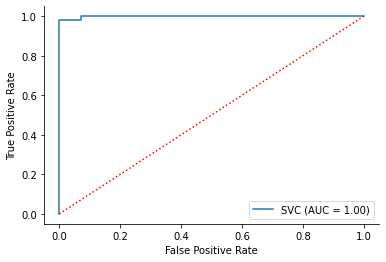

In [16]:
metrics.plot_roc_curve(clf, test_features, Y_test)
plt.plot([0,1],[0,1], 'r:')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
#plt.title("Linear SVM CLassifier Performance")
sns.despine()
plt.show()


In [9]:
def shannon_entropy(x):
    counts = x.value_counts()
    she = entropy(counts, axis =0)
    return she

def spectral_entropy(x, sf, method='fft', nperseg=None, normalize=False):
    x = np.array(x)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(x, sf)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg)
    psd_norm = np.divide(psd, psd.sum())
    se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
    if normalize:
        se /= np.log2(psd_norm.size)
    return se

def rms(x):
    rms_val = np.sqrt(np.mean(x**2))
    return rms_val

def var(x):
    return np.var(x)

def svd_entropy(x, order=3, delay=1, normalize=False):
    x = np.array(x)
    mat = _embed(x, order=order, delay=delay)
    W = np.linalg.svd(mat, compute_uv=False)
    # Normalize the singular values
    W /= sum(W)
    svd_e = -np.multiply(W, np.log2(W)).sum()
    if normalize:
        svd_e /= np.log2(order)
    return svd_e

def perm_entropy(x, order=3, delay=1, normalize=False):
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe

def delta_power(x, sf = 173.61, low = 0.5, high = 4):
    data = x
    win = 4 * sf
    freqs, psd = signal.welch(data, sf, nperseg=win)

    # Find intersecting values in frequency vector
    idx_delta = np.logical_and(freqs >= low, freqs <= high)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

    # Compute the absolute power by approximating the area under the curve
    delta_power_val = simps(psd[idx_delta], dx=freq_res)
    return delta_power_val

def theta_power(x, sf = 173.61, low = 4.01, high = 8):
    data = x
    win = 4 * sf
    freqs, psd = signal.welch(data, sf, nperseg=win)

    # Find intersecting values in frequency vector
    idx_delta = np.logical_and(freqs >= low, freqs <= high)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

    # Compute the absolute power by approximating the area under the curve
    delta_power_val = simps(psd[idx_delta], dx=freq_res)
    return delta_power_val


In [8]:
def get_features(paths):
    vals = []
    for file in paths:
        with open(file) as f:
            data_oi = [int(val) for val in f.read().splitlines()]
            pd_series= pd.Series(data_oi)
            she = shannon_entropy(pd_series)
            se = spectral_entropy(pd_series, sf= 173.61)
            #svde = svd_entropy(pd_series)
            perme = perm_entropy(pd_series)
            rms_val = rms(pd_series)
            delta_power_val = delta_power(pd_series)
            theta_power_val = theta_power(pd_series)
            #var_val = var(pd_series)
            vals.append([she, se, perme, delta_power_val, theta_power_val])
    return np.array(vals)